In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

In [2]:
import warnings

warnings.filterwarnings("ignore")

## clustering with k-means

In [3]:
file_path = 'Online Retail.xlsx'

In [4]:
#import data
df1 = pd.read_excel(file_path)

In [5]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [6]:
# deleting null value
df1 = df1.dropna()

In [7]:
#remove duplicates rows
duplicates = df1.duplicated()

df1.drop_duplicates(inplace=True)

In [8]:

df1['InvoiceNo']= df1['InvoiceNo'].astype('str')

# remove cancelled transactions identified with invoice starting with letter 'c'
dataset = df1[~df1['InvoiceNo'].str.startswith('c')]

In [9]:
dataset.describe()

,Quantity,UnitPrice,CustomerID
count,401604.000000,401604.000000,401604.000000
mean,12.183273,3.474064,15281.160818
std,250.283037,69.764035,1714.006089
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13939.000000
50%,5.000000,1.950000,15145.000000
75%,12.000000,3.750000,16784.000000
max,80995.000000,38970.000000,18287.000000


In [10]:

#keeping only positive values
dataset = dataset[dataset['UnitPrice'] > 0]

In [11]:
dataset = dataset[dataset['Quantity'] > 0]

In [12]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392692 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    392692 non-null  object        
 1   StockCode    392692 non-null  object        
 2   Description  392692 non-null  object        
 3   Quantity     392692 non-null  int64         
 4   InvoiceDate  392692 non-null  datetime64[ns]
 5   UnitPrice    392692 non-null  float64       
 6   CustomerID   392692 non-null  float64       
 7   Country      392692 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.0+ MB


In [13]:
# creation of customer dataset 
customer = dataset.groupby('CustomerID').agg({
    'Quantity': 'mean',                  # average quantity
    'UnitPrice': 'mean'                # average price     
}).reset_index()

# rename columns
customer.columns = ['CustomerID','avg_Quantity', 'avg_price']



In [14]:
customer.head()

,CustomerID,avg_Quantity,avg_price
0,12346.0,74215.000000,1.040000
1,12347.0,13.505495,2.644011
2,12348.0,75.516129,5.764839
3,12349.0,8.643836,8.289041
4,12350.0,11.588235,3.841176


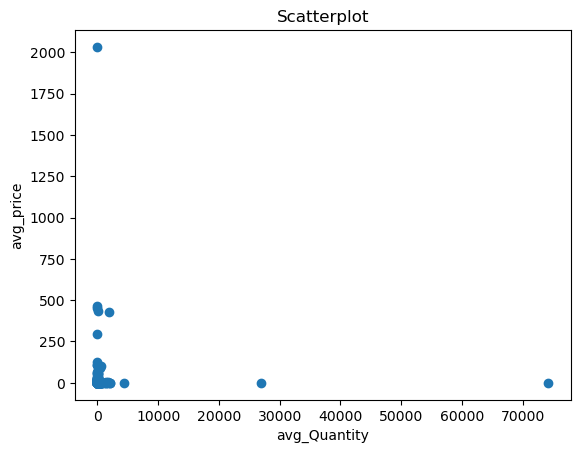

In [15]:
# scatterplot of variables
plt.scatter(customer['avg_Quantity'], customer['avg_price'])
plt.xlabel('avg_Quantity')
plt.ylabel('avg_price')
plt.title('Scatterplot')
plt.show()

In [16]:

# Remove ouliers from avg_Quantity
Q1_Total_Sale = customer['avg_Quantity'].quantile(0.25)
Q3_Total_Sale = customer['avg_Quantity'].quantile(0.75)
IQR_Total_Sale = Q3_Total_Sale - Q1_Total_Sale
lower_bound_Total_Sale = Q1_Total_Sale - 1.5 * IQR_Total_Sale
upper_bound_Total_Sale = Q3_Total_Sale + 1.5 * IQR_Total_Sale
customer = customer[(customer['avg_Quantity'] >= lower_bound_Total_Sale) & (customer['avg_Quantity'] <= upper_bound_Total_Sale)]

# remove outliers from avg_price
Q1_NumTransactions = customer['avg_price'].quantile(0.25)
Q3_NumTransactions = customer['avg_price'].quantile(0.75)
IQR_NumTransactions = Q3_NumTransactions - Q1_NumTransactions
lower_bound_NumTransactions = Q1_NumTransactions - 1.5 * IQR_NumTransactions
upper_bound_NumTransactions = Q3_NumTransactions + 1.5 * IQR_NumTransactions
customer = customer[(customer['avg_price'] >= lower_bound_NumTransactions) & (customer['avg_price'] <= upper_bound_NumTransactions)]





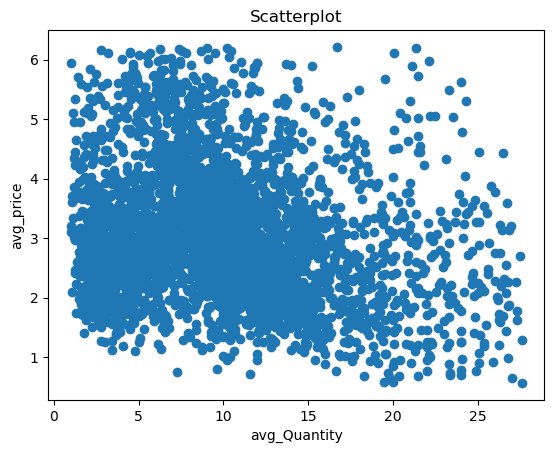

In [17]:
# scatterplot of variables
plt.scatter(customer['avg_Quantity'], customer['avg_price'])
plt.xlabel('avg_Quantity')
plt.ylabel('avg_price')
plt.title('Scatterplot')
plt.show()

In [18]:
customer.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3696 entries, 1 to 4337
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   CustomerID    3696 non-null   float64
 1   avg_Quantity  3696 non-null   float64
 2   avg_price     3696 non-null   float64
dtypes: float64(3)
memory usage: 115.5 KB


In [19]:
# Select columns for clustering 
X = customer[['avg_Quantity', 'avg_price']]

#Scaling the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

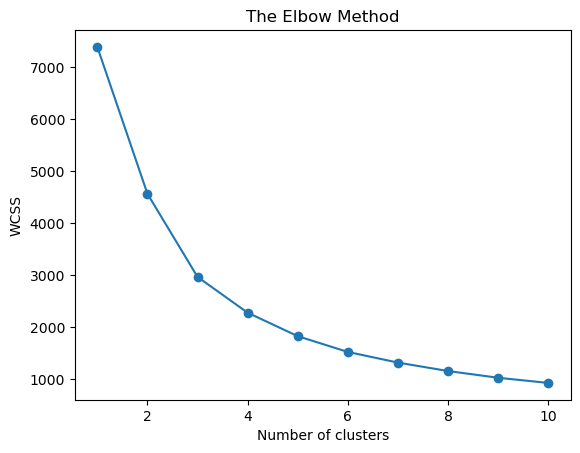

In [20]:
#Using the elbow method to find the optimal number of clusters
from sklearn.cluster import KMeans
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 0)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss, marker='o')
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [21]:
# clustering using K-Means
n_clusters = 4  
kmeans = KMeans(n_clusters=n_clusters,init = 'k-means++', random_state=42)




In [22]:
# adding columns with clusters in customer dataset
customer['Cluster'] = kmeans.fit_predict(X_scaled)

In [23]:
customer.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3696 entries, 1 to 4337
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   CustomerID    3696 non-null   float64
 1   avg_Quantity  3696 non-null   float64
 2   avg_price     3696 non-null   float64
 3   Cluster       3696 non-null   int32  
dtypes: float64(3), int32(1)
memory usage: 129.9 KB


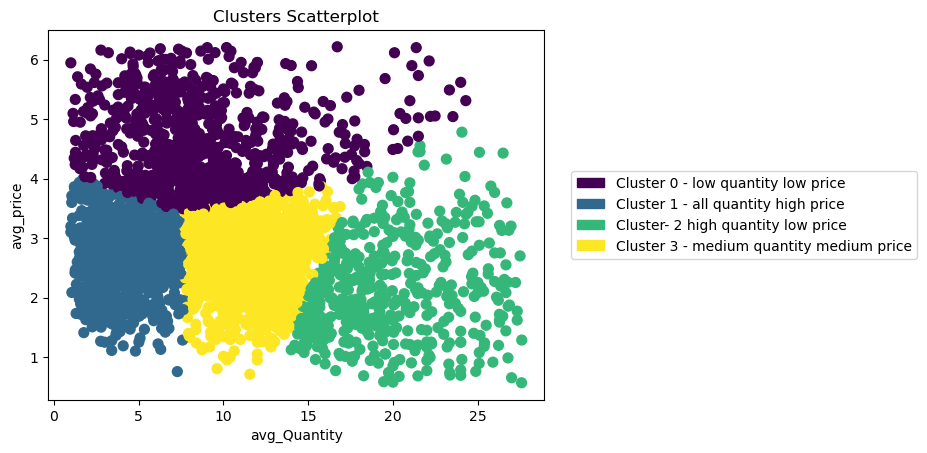

In [24]:
# scatter plot with clusters using original variables
cluster_names = ['Cluster 0 - low quantity low price', 'Cluster 1 - all quantity high price', 'Cluster- 2 high quantity low price', 'Cluster 3 - medium quantity medium price']

scatter = plt.scatter(customer['avg_Quantity'], customer['avg_price'], c=customer['Cluster'], cmap='viridis', s=50)

colors = np.unique(customer['Cluster'])
legend_patches = [mpatches.Patch(color=scatter.cmap(scatter.norm(c)), label=cluster_names[int(c)]) for c in colors]
plt.title('Clusters Scatterplot')
plt.xlabel('avg_Quantity')
plt.ylabel('avg_price')
plt.legend(handles=legend_patches, bbox_to_anchor=(1.04, 0.5), loc='center left')
plt.show()


In [25]:
# merge original dataset with customer dataset to include the columns with the clusters
dataset = dataset.merge(customer[['CustomerID', 'Cluster']], on='CustomerID', how='left')


In [26]:
# delete null values
dataset = dataset.dropna(subset=['Cluster'])


## Classification KNN

In [27]:
# selecting variables for classifications
Z= dataset[['UnitPrice', 'Quantity']]

In [28]:
#divide in training and test set
X_train, X_test, y_train, y_test = train_test_split(Z, dataset['Cluster'], test_size=0.25, random_state=42)

In [29]:
Z

,UnitPrice,Quantity
0,2.55,6
1,3.39,6
2,2.75,8
3,3.39,6
4,3.39,6
...,...,...
392687,0.85,12
392688,2.10,6
392689,4.15,4
392690,4.15,4


In [30]:
#Scaling the data

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


In [31]:
#Training the model
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier (n_neighbors = 5, metric = 'minkowski', p = 2)
classifier.fit(X_train, y_train)

KNeighborsClassifier()

In [32]:
#create variable with predictions
y_pred = classifier.predict(X_test)

In [33]:
# assess the model
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
accuracy_score(y_test, y_pred)

0.5594760998544722

In [34]:
# Predicting a new result
print(classifier.predict(sc.transform([[3,3]])))

[1.]


## Classification with Random Forest

In [35]:
from sklearn.ensemble import RandomForestClassifier

# Random Forest
class_rf = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)

# training the algorithm
class_rf.fit(X_train, y_train)

# prediction
y_pred = class_rf.predict(X_test)

# accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.6254002015000559

Confusion Matrix:
[[ 2979  3326   410  9139]
 [ 1109 31806   182  4829]
 [  579  1165   993  5970]
 [ 2170  3950   634 20089]]


In [36]:
# Predicting a new result
print(classifier.predict(sc.transform([[20,5]])))

[3.]
